# Import packages

In [1]:
import pandas as pd
import numpy as np
import sqlite3

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm

from datetime import datetime

import matplotlib.pyplot as plt

# Import dataset

In [2]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("../sncf_lostnfound.sqlite")
df = pd.read_sql_query("SELECT * from ObjetTrouve", con)

# Verify that result of SQL query is stored in the dataframe
print(df.head())

con.close()

   id          gare                        date  \
0   1  Lille Europe  2016-12-31 17:49:05.000000   
1   2  Lille Europe  2016-12-31 16:09:12.000000   
2   3  Lille Europe  2016-12-31 15:52:03.000000   
3   4  Lille Europe  2016-12-31 13:55:43.000000   
4   5  Lille Europe  2016-12-31 13:41:39.000000   

                                                type  \
0       Porte-monnaie / portefeuille, argent, titres   
1  Appareils électroniques, informatiques, appare...   
2           Pièces d'identités et papiers personnels   
3                Bagagerie: sacs, valises, cartables   
4                Bagagerie: sacs, valises, cartables   

                                     nature  
0                                  Chéquier  
1  Tablette tactile protégée (étui, housse)  
2                              Carte Vitale  
3                 Valise, sac sur roulettes  
4                                Sac à main  


# Prepare dataset - preprocessing, 

In [3]:
df.head()

,id,gare,date,type,nature
0,1,Lille Europe,2016-12-31 17:49:05.000000,"Porte-monnaie / portefeuille, argent, titres",Chéquier
1,2,Lille Europe,2016-12-31 16:09:12.000000,"Appareils électroniques, informatiques, appare...","Tablette tactile protégée (étui, housse)"
2,3,Lille Europe,2016-12-31 15:52:03.000000,Pièces d'identités et papiers personnels,Carte Vitale
3,4,Lille Europe,2016-12-31 13:55:43.000000,"Bagagerie: sacs, valises, cartables","Valise, sac sur roulettes"
4,5,Lille Europe,2016-12-31 13:41:39.000000,"Bagagerie: sacs, valises, cartables",Sac à main


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22200 entries, 0 to 22199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      22200 non-null  int64 
 1   gare    22200 non-null  object
 2   date    22200 non-null  object
 3   type    22200 non-null  object
 4   nature  22200 non-null  object
dtypes: int64(1), object(4)
memory usage: 867.3+ KB


In [5]:
df['datetime_obj'] = pd.to_datetime(df['date'])

In [6]:
df['year'] = pd.DatetimeIndex(df['datetime_obj']).year
df['month'] = pd.DatetimeIndex(df['datetime_obj']).month
df['month_name'] = pd.DatetimeIndex(df['datetime_obj']).month_name()
df['day'] = pd.DatetimeIndex(df['datetime_obj']).day
df['day_of_week'] = pd.DatetimeIndex(df['datetime_obj']).day_name()

df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)


df['year_week'] = df['datetime_obj'].dt.strftime('%Y-%U')
df['date_only'] = df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + df['day'].astype(str)

# Understanding ARIMA

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. Know more about parameters of ARIMA and its limitations, in this free video tutorial

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

## Pre-processing

In [7]:
df_year_month_full = df.groupby(by = ['year_month'])['year_month'].count().reset_index(name='item_lost')
df_year_month = df_year_month_full['item_lost'].to_frame()

## Load model

In [8]:
model_arima_yr_mth = pm.auto_arima(df_year_month.item_lost, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_arima_yr_mth.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=902.371, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=914.151, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=908.862, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=904.176, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=912.162, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=904.371, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=904.371, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=903.234, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=909.005, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=906.205, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=900.815, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=902.337, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=906.907, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=902.814, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=902.8

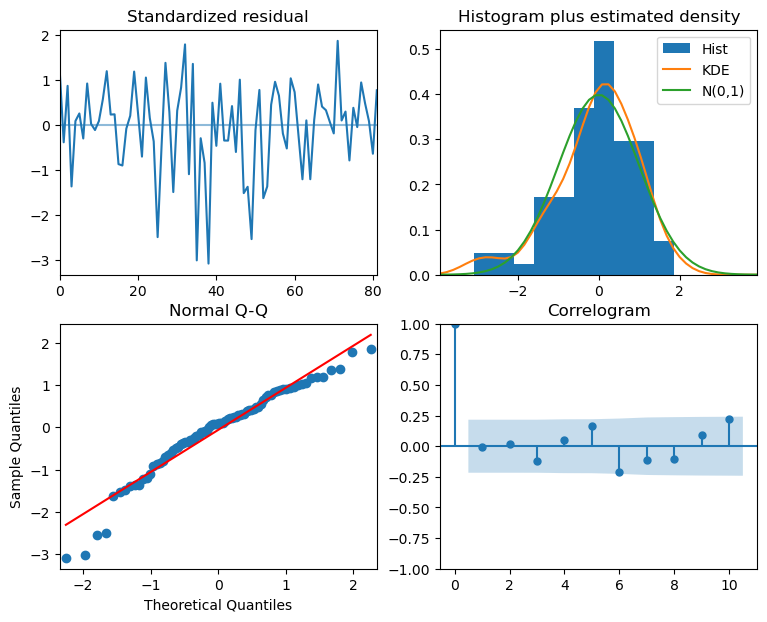

In [9]:
model_arima_yr_mth.plot_diagnostics(figsize=(9,7))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

## Evaluate the seasonality

In [10]:

result = adfuller(df_year_month.item_lost.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.571747
p-value: 0.497769


more than 0.05 --> not stationary

## Difference the series and see how the autocorrelation plot looks like.

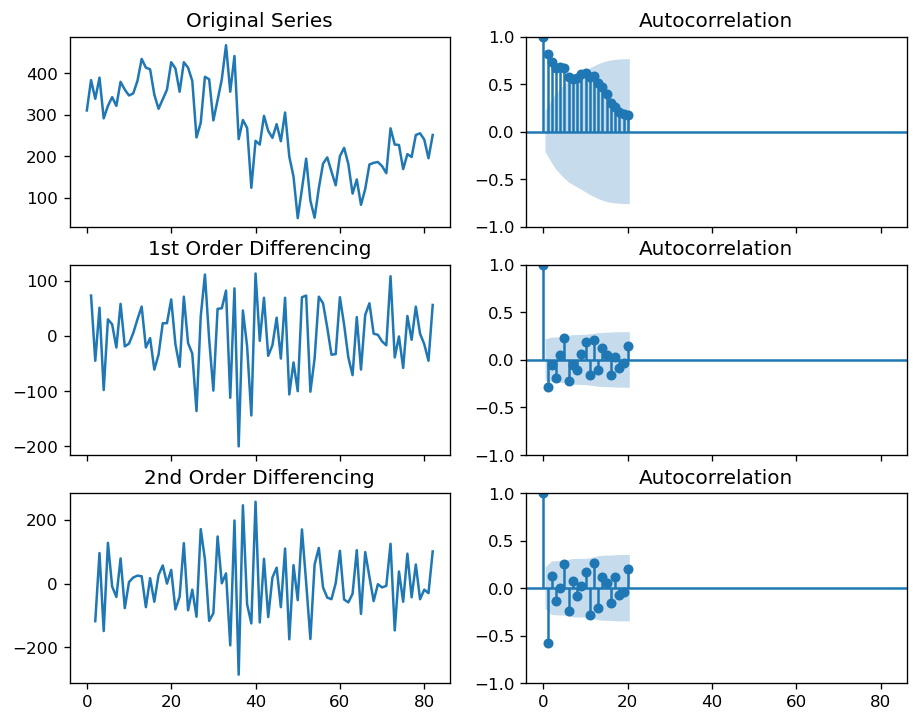

In [11]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_year_month.item_lost); axes[0, 0].set_title('Original Series')
plot_acf(df_year_month.item_lost, ax=axes[0, 1])
# axes[0, 1].set(ylim=(0,5), xlim=(-1,25))

# 1st Differencing
axes[1, 0].plot(df_year_month.item_lost.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_year_month.item_lost.diff().dropna(), ax=axes[1, 1])
# axes[1, 1].set(ylim=(0,5), xlim=(-1,25))

# 2nd Differencing
axes[2, 0].plot(df_year_month.item_lost.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_year_month.item_lost.diff().diff().dropna(), ax=axes[2, 1])
# axes[2, 1].set(ylim=(0,5), xlim=(-1,25))

plt.show()

c:\Users\Apprenant\anaconda3\envs\timeseries\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


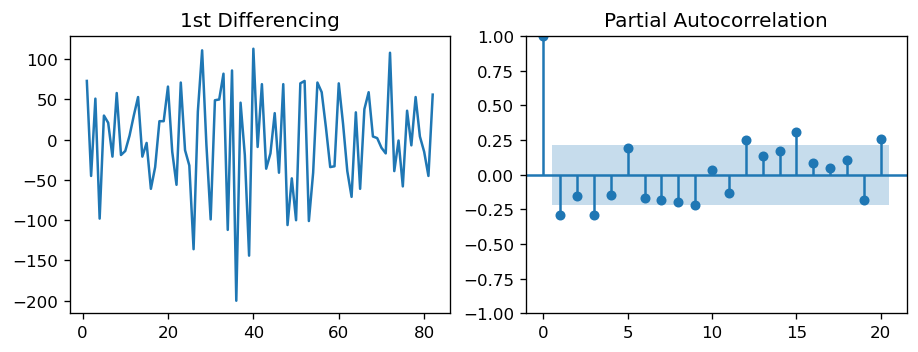

In [12]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_year_month.item_lost.diff()); axes[0].set_title('1st Differencing'); 
axes[1].set(ylim=(0,5)); 
plot_pacf(df_year_month.item_lost.diff().dropna(), ax=axes[1])

# axes[0].plot(df_input.item_lost); axes[0].set_title('Original')
# axes[1].set(ylim=(0,5))
# plot_pacf(df_input.item_lost.dropna(), ax=axes[1])

plt.show()

p = 1

## Find the MA term

An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

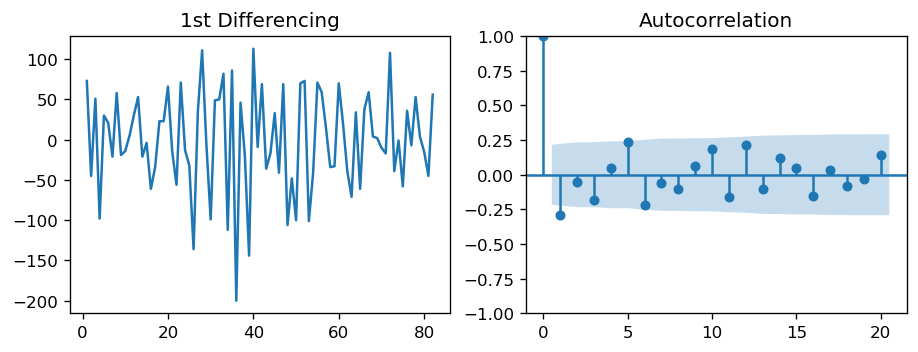

In [13]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_year_month.item_lost.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_acf(df_year_month.item_lost.diff().dropna(), ax=axes[1])

plt.show()

q = 2

# Arima Model

In [14]:
df_year_month_train = df_year_month[:-9]
df_year_month_test = df_year_month[-9::]

In [15]:
model_arima_yr_mth_train = pm.auto_arima(df_year_month_train.item_lost, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_arima_yr_mth.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=809.558, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=819.698, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=815.341, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=811.367, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=817.720, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=811.556, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=811.556, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=810.502, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=815.441, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=813.545, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=808.429, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=809.557, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=813.389, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=810.428, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=810.4

# SARIMA

In [16]:
df_date_month = df_year_month_full
df_date_month['year_month'] = pd.to_datetime(df_date_month['year_month'])

In [17]:
df_date_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year_month  83 non-null     datetime64[ns]
 1   item_lost   83 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.4 KB


In [18]:
df_date_month.set_index('year_month', inplace=True,drop=True)
df_date_month = df_date_month.sort_index()

df_date_month_train = df_date_month[:-9]
df_date_month_test = df_date_month[-9::]

In [19]:
# Seasonal - fit stepwise auto-ARIMA
smodeltrain = pm.auto_arima(df_date_month_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodeltrain.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=695.745, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=672.421, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=694.660, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=670.011, Time=0.25 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=667.575, Time=0.30 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=667.650, Time=0.65 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.27 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=671.601, Time=0.20 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.53 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   74
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -329.787
Date:                              Fri, 06 Jan 2023   AIC                            667.575
Time:                                      11:36:54   BIC                            676.018
Sample:                                           0   HQIC                           670.884
                                               - 74                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3109      0.136     -2.286      0.022      -0.577      -0.044
ar.S.L12      -0.1541      0.267     -0.577      0.564      -0.678       0.370
ma.S.L12      -0.8320      0.640     -1.300      0.194      -2.087       0.423
sigma2      2241.3275   1023.433      2.190      0.029     235.436    4247.219
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 6.10
Prob(Q):                              0.51   Prob(JB):                         0.05
Heteroskedasticity (H):               1.45   Skew:                            -0.70
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

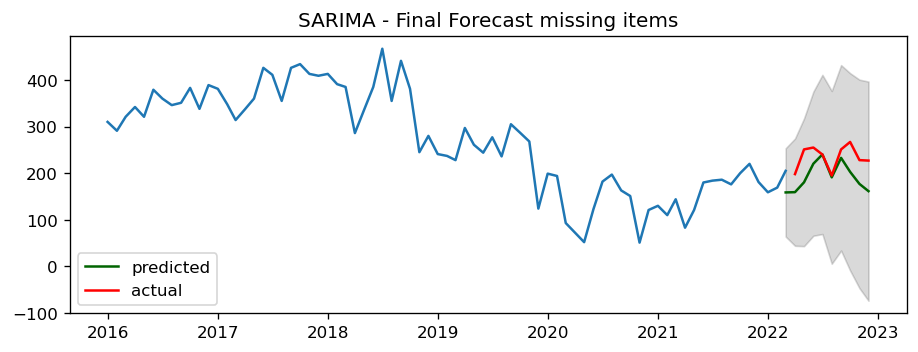

In [20]:
# Forecast
n_periods = 10
fitted, confint = smodeltrain.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df_date_month_train.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_date_month_train)
plt.plot(fitted_series, color='darkgreen', label='predicted')
plt.plot(df_date_month_test,color='red', label='actual')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.legend(loc=3)
plt.title("SARIMA - Final Forecast missing items")
plt.show()

In [21]:
fitted_series_mae = fitted_series[1:]

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print ("MAE for classical approach:",mean_absolute_error(df_date_month_test['item_lost'], fitted_series_mae))

MAE for classical approach: 38.5620292945229
